# Crime Forecasting Using Channel-Enhanced BiLSTM with CBAM-Based Temporal Attention: A Seven-Day Predictive Framework

Research Question:
To what extent can deep learning-based temporal forecasting frameworks, with added attention models and informed by contextual variables, including weather, holiday, and recent behavioural patterns, predict crime patterns in an urban area, and how these frameworks vary in their predictive accuracy, generalisation power and computational resource consumption?


Data set used: Chicago Crime Data (2019–2025) – from Chicago Data Portal

Chicago Weather Data (2019–2025) – from NOAA / Midway Airport

In [88]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras import layers, Model, Input
from lime import lime_tabular
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import metrics
import time
import psutil
import os
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input, Permute, Multiply, Flatten, GRU, Lambda, RepeatVector
from tensorflow.keras import Model
import plotly.express as px
from datetime import timedelta
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Flatten, GlobalAveragePooling1D, GlobalMaxPooling1D, Reshape, Conv1D, Add, Activation, Multiply, Lambda, Concatenate
from tensorflow.keras.models import Model




## 1. Data Import & Description

In [91]:
# Load main crime dataset (CSV)
df = pd.read_csv('/content/drive/MyDrive/Crime_hotspot/Dataset/Crimes_-_2019_to_Present_20250930.csv')

# Load weather dataset (Excel file)
weather = pd.read_excel('/content/drive/MyDrive/Crime_hotspot/Dataset/weather_data.xls')


In [92]:
weather

,Local time in Chicago / Midway (airport),T,Po,P,Pa,U,DD,Ff,ff10,ff3,...,Cm,Ch,VV,Td,RRR,tR,E,Tg,E',sss
0,20.09.2025 22:00,22.2,745.6,761.8,NaN,82.0,Wind blowing from the north-northeast,2.0,NaN,NaN,...,NaN,NaN,16.0,18.9,Trace of precipitation,3.0,NaN,NaN,NaN,NaN
1,20.09.2025 16:00,25.6,745.9,762.1,NaN,60.0,"Calm, no wind",0.0,NaN,NaN,...,NaN,NaN,16.0,17.2,0.5,3.0,NaN,NaN,NaN,NaN
2,20.09.2025 10:00,23.3,747.1,763.4,NaN,69.0,"Calm, no wind",0.0,NaN,NaN,...,NaN,NaN,16.0,17.2,NaN,NaN,NaN,NaN,NaN,NaN
3,20.09.2025 04:00,22.2,746.4,762.5,NaN,68.0,Wind blowing from the south,5.0,NaN,NaN,...,NaN,NaN,16.0,16.1,Trace of precipitation,3.0,NaN,NaN,NaN,NaN
4,19.09.2025 22:00,26.1,745.6,761.5,NaN,52.0,Wind blowing from the north-northeast,2.0,NaN,NaN,...,NaN,NaN,16.0,15.6,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9859,02.01.2019 03:00,-2.2,751.4,769.5,NaN,88.0,Wind blowing from the south-west,2.0,NaN,NaN,...,NaN,NaN,9.0,-3.9,Trace of precipitation,3.0,NaN,NaN,NaN,NaN
9860,01.01.2019 21:00,-2.2,752.9,770.9,NaN,85.0,Wind blowing from the north-northwest,3.0,NaN,NaN,...,NaN,NaN,12.0,-4.4,Trace of precipitation,3.0,NaN,NaN,NaN,NaN
9861,01.01.2019 15:00,-1.7,752.4,770.2,NaN,85.0,Wind blowing from the north-northeast,4.0,NaN,NaN,...,NaN,NaN,12.0,-3.9,Trace of precipitation,3.0,NaN,NaN,NaN,NaN
9862,01.01.2019 09:00,-0.6,751.9,769.6,NaN,85.0,Wind blowing from the north,4.0,NaN,NaN,...,NaN,NaN,16.0,-2.8,Trace of precipitation,3.0,NaN,NaN,NaN,NaN


In [93]:
weather.columns

Index(['Local time in Chicago / Midway (airport)', 'T', 'Po', 'P', 'Pa', 'U',
       'DD', 'Ff', 'ff10', 'ff3', 'N', 'WW', 'W1', 'W2', 'Tn', 'Tx', 'Cl',
       'Nh', 'H', 'Cm', 'Ch', 'VV', 'Td', 'RRR', 'tR', 'E', 'Tg', 'E'', 'sss'],
      dtype='object')

# CRIME

In [94]:
df

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,11555127,JC101856,01/01/2019 03:57:00 PM,0000X W WASHINGTON ST,1310,CRIMINAL DAMAGE,TO PROPERTY,BANK,False,False,...,42.0,32.0,14,1176114.0,1900822.0,2019,01/10/2019 03:16:50 PM,41.883217,-87.628754,"(41.883217427, -87.628753807)"
1,11554052,JC101651,01/01/2019 04:00:00 PM,001XX S PULASKI RD,0460,BATTERY,SIMPLE,STREET,True,False,...,28.0,26.0,08B,1149754.0,1898946.0,2019,01/10/2019 03:16:50 PM,41.878623,-87.725598,"(41.87862256, -87.72559838)"
2,11553808,JC101414,01/01/2019 04:00:00 PM,050XX W CONGRESS PKWY,0820,THEFT,$500 AND UNDER,STREET,False,False,...,29.0,25.0,06,1142590.0,1897205.0,2019,01/10/2019 03:16:50 PM,41.873981,-87.751947,"(41.873981228, -87.751946738)"
3,11553354,JC100903,01/01/2019 04:00:00 PM,0000X N MICHIGAN AVE,0890,THEFT,FROM BUILDING,RESTAURANT,False,False,...,42.0,32.0,06,1177309.0,1900530.0,2019,01/10/2019 03:16:50 PM,41.882389,-87.624375,"(41.882389156, -87.624374606)"
4,11553403,JC101041,01/01/2019 04:00:00 PM,028XX N CLARK ST,0820,THEFT,$500 AND UNDER,STREET,False,False,...,44.0,6.0,06,1171359.0,1919209.0,2019,01/10/2019 03:16:50 PM,41.933778,-87.645673,"(41.933778153, -87.645673011)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1616332,13975969,JJ425352,09/21/2025 12:00:00 AM,031XX S WELLS ST,0710,THEFT,THEFT FROM MOTOR VEHICLE,RESIDENCE,False,False,...,11.0,34.0,06,1175131.0,1884127.0,2025,09/28/2025 03:42:59 PM,41.837427,-87.632864,"(41.837427273, -87.632863567)"
1616333,13976430,JJ425187,09/21/2025 12:00:00 AM,021XX S CALUMET AVE,1320,CRIMINAL DAMAGE,TO VEHICLE,HOTEL / MOTEL,False,False,...,3.0,33.0,14,1178840.0,1890202.0,2025,09/28/2025 03:42:59 PM,41.854014,-87.619068,"(41.854013684, -87.619068382)"
1616334,13975864,JJ425410,09/21/2025 12:00:00 AM,043XX W WABANSIA AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,OTHER (SPECIFY),False,False,...,26.0,23.0,11,1146986.0,1910940.0,2025,09/28/2025 03:42:59 PM,41.911589,-87.735455,"(41.911588738, -87.735455121)"
1616335,13976000,JJ425621,09/21/2025 12:00:00 AM,050XX N WOLCOTT AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,...,40.0,4.0,11,1162901.0,1933808.0,2025,09/28/2025 03:42:59 PM,41.974020,-87.676344,"(41.974020487, -87.676344418)"


In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1616337 entries, 0 to 1616336
Data columns (total 22 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   ID                    1616337 non-null  int64  
 1   Case Number           1616337 non-null  object 
 2   Date                  1616337 non-null  object 
 3   Block                 1616337 non-null  object 
 4   IUCR                  1616337 non-null  object 
 5   Primary Type          1616337 non-null  object 
 6   Description           1616337 non-null  object 
 7   Location Description  1607717 non-null  object 
 8   Arrest                1616337 non-null  bool   
 9   Domestic              1616337 non-null  bool   
 10  Beat                  1616337 non-null  int64  
 11  District              1616337 non-null  int64  
 12  Ward                  1616288 non-null  float64
 13  Community Area        1616227 non-null  float64
 14  FBI Code              1616337 non-

In [96]:
df.isna().sum()

,0
ID,0
Case Number,0
Date,0
Block,0
IUCR,0
Primary Type,0
Description,0
Location Description,8620
Arrest,0
Domestic,0


In [97]:
df['Primary Type'].value_counts()

,count
Primary Type,
THEFT,357459
BATTERY,293815
CRIMINAL DAMAGE,181212
ASSAULT,141981
DECEPTIVE PRACTICE,116496
MOTOR VEHICLE THEFT,114060
OTHER OFFENSE,102949
ROBBERY,57327
BURGLARY,55135


In [98]:
df['Date'] = pd.to_datetime(df['Date'])

df.set_index('Date', inplace=True)

In [99]:
df['Ward'].unique()

array([42., 28., 29., 44., 39., 10., 16., 17.,  7., 26., 27., 24., 21.,
       15., 14., 22.,  8.,  6.,  5., 46., 35., 37.,  9.,  2., 25.,  3.,
        1., 32., 31., 20., 18., 13., 12., 41., 49., 11., 36., 43., 34.,
        4., 45., 50., 19., 38., 47., 30., 33., 40., 23., 48., nan])

In [100]:
df['Primary Type'].unique()

array(['CRIMINAL DAMAGE', 'BATTERY', 'THEFT',
       'OFFENSE INVOLVING CHILDREN', 'NARCOTICS',
       'INTERFERENCE WITH PUBLIC OFFICER', 'ASSAULT', 'OTHER OFFENSE',
       'CRIMINAL TRESPASS', 'MOTOR VEHICLE THEFT', 'SEX OFFENSE',
       'DECEPTIVE PRACTICE', 'BURGLARY', 'ROBBERY',
       'PUBLIC PEACE VIOLATION', 'WEAPONS VIOLATION', 'INTIMIDATION',
       'CRIMINAL SEXUAL ASSAULT', 'CRIM SEXUAL ASSAULT', 'STALKING',
       'ARSON', 'CONCEALED CARRY LICENSE VIOLATION', 'HOMICIDE',
       'PROSTITUTION', 'LIQUOR LAW VIOLATION', 'HUMAN TRAFFICKING',
       'KIDNAPPING', 'GAMBLING', 'OBSCENITY', 'OTHER NARCOTIC VIOLATION',
       'NON-CRIMINAL', 'PUBLIC INDECENCY', 'RITUALISM'], dtype=object)

## 2.Data Cleaning & Preprocessing

### 2.1.FILTERING DATA

In [101]:
# Filter records for Community Area = 28 AND crime type = THEFT
filtered_df = df[(df['Community Area'] == 28) & (df['Primary Type'] == 'THEFT')]

In [102]:

filtered_df = filtered_df.sort_index()
filtered_df

,ID,Case Number,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01 16:30:00,11586815,JC141509,001XX N GREEN ST,0890,THEFT,FROM BUILDING,RESTAURANT,False,False,1224,...,27.0,28.0,06,1170711.0,1901002.0,2019,02/08/2019 04:05:45 PM,41.883831,-87.648589,"(41.883831371, -87.648588508)"
2019-01-01 17:53:00,11553411,JC101053,008XX W FULTON MARKET,0890,THEFT,FROM BUILDING,BAR OR TAVERN,False,False,1214,...,27.0,28.0,06,1170577.0,1902075.0,2019,01/10/2019 03:16:50 PM,41.886779,-87.649049,"(41.886778688, -87.649049147)"
2019-01-02 05:30:00,11555377,JC103349,006XX W MONROE ST,0810,THEFT,OVER $500,STREET,False,False,121,...,42.0,28.0,06,1172247.0,1899816.0,2019,01/10/2019 03:16:50 PM,41.880543,-87.642983,"(41.88054314, -87.642983249)"
2019-01-02 07:00:00,11555657,JC102803,002XX S CANAL ST,0820,THEFT,$500 AND UNDER,OTHER COMMERCIAL TRANSPORTATION,False,False,121,...,42.0,28.0,06,1173178.0,1899203.0,2019,01/10/2019 03:16:50 PM,41.878840,-87.639583,"(41.878840427, -87.639582928)"
2019-01-02 08:00:00,11576334,JC128314,009XX W WASHINGTON BLVD,0810,THEFT,OVER $500,VEHICLE - DELIVERY TRUCK,False,False,1224,...,25.0,28.0,06,1170224.0,1900729.0,2019,01/27/2019 04:03:13 PM,41.883093,-87.650385,"(41.883092889, -87.650384784)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-20 05:00:00,13972924,JJ421750,010XX S DESPLAINES ST,0810,THEFT,OVER $500,STREET,False,True,124,...,28.0,28.0,06,1172075.0,1895790.0,2025,09/28/2025 03:42:59 PM,41.869499,-87.643734,"(41.869499313, -87.643733583)"
2025-09-20 12:05:00,13972919,JJ421748,010XX W LAKE ST,0860,THEFT,RETAIL THEFT,DRUG STORE,False,False,1214,...,27.0,28.0,06,1169328.0,1901620.0,2025,09/28/2025 03:42:59 PM,41.885557,-87.653649,"(41.885557376, -87.65364901)"
2025-09-20 14:30:00,13973042,JJ421976,012XX S CANAL ST,0820,THEFT,$500 AND UNDER,PARKING LOT / GARAGE (NON RESIDENTIAL),False,False,124,...,28.0,28.0,06,1173315.0,1894646.0,2025,09/28/2025 03:42:59 PM,41.866333,-87.639215,"(41.866332671, -87.639215203)"


In [103]:

filtered_df.isna().sum()

,0
ID,0
Case Number,0
Block,0
IUCR,0
Primary Type,0
Description,0
Location Description,0
Arrest,0
Domestic,0
Beat,0


In [104]:
# HANDLING NULL VALUES

# Replace missing Latitude values with the mean Latitude of the filtered area
filtered_df["Latitude"].fillna(filtered_df["Latitude"].mean(), inplace=True)

# Replace missing Longitude values with the mean Longitude
filtered_df["Longitude"].fillna(filtered_df["Longitude"].mean(), inplace=True)

# Replace missing X Coordinate values with the mean X Coordinate
filtered_df["X Coordinate"].fillna(filtered_df["X Coordinate"].mean(), inplace=True)

# Replace missing Y Coordinate values with the mean Y Coordinate
filtered_df["Y Coordinate"].fillna(filtered_df["Y Coordinate"].mean(), inplace=True)

# Replace missing Location values using (mean_latitude, mean_longitude)
filtered_df["Location"].fillna(
    f"({filtered_df['Latitude'].mean()}, {filtered_df['Longitude'].mean()})",
    inplace=True
)

In [105]:
filtered_df.isna().sum()

,0
ID,0
Case Number,0
Block,0
IUCR,0
Primary Type,0
Description,0
Location Description,0
Arrest,0
Domestic,0
Beat,0


## 3. EDA

### 3.1 CRIME data

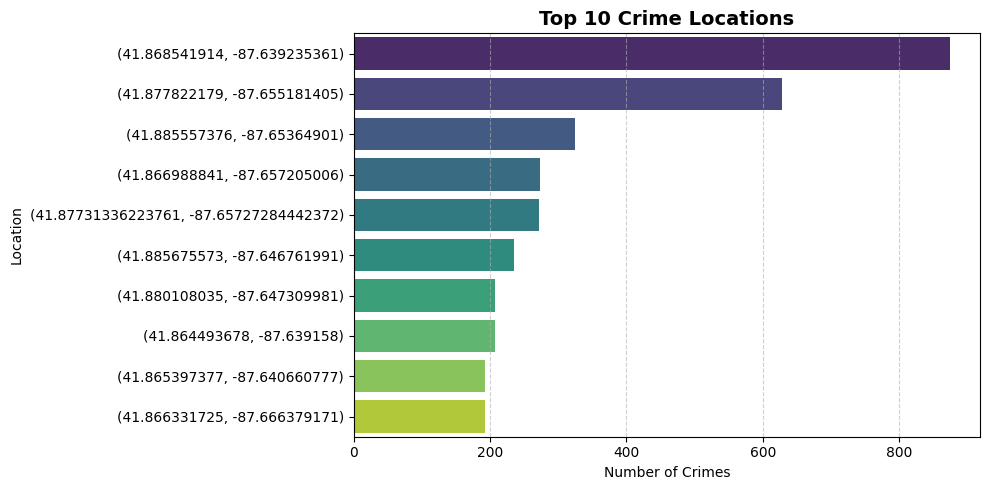

In [106]:
# Top 10 most frequent crime locations in the filtered dataset
plt.figure(figsize=(10,5))

# Get top 10 locations by frequency
top10 = filtered_df['Location'].value_counts().head(10)

# Horizontal barplot
sns.barplot(x=top10.values, y=top10.index, palette='viridis')

plt.title('Top 10 Crime Locations', fontsize=14, weight='bold')
plt.xlabel('Number of Crimes')
plt.ylabel('Location')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

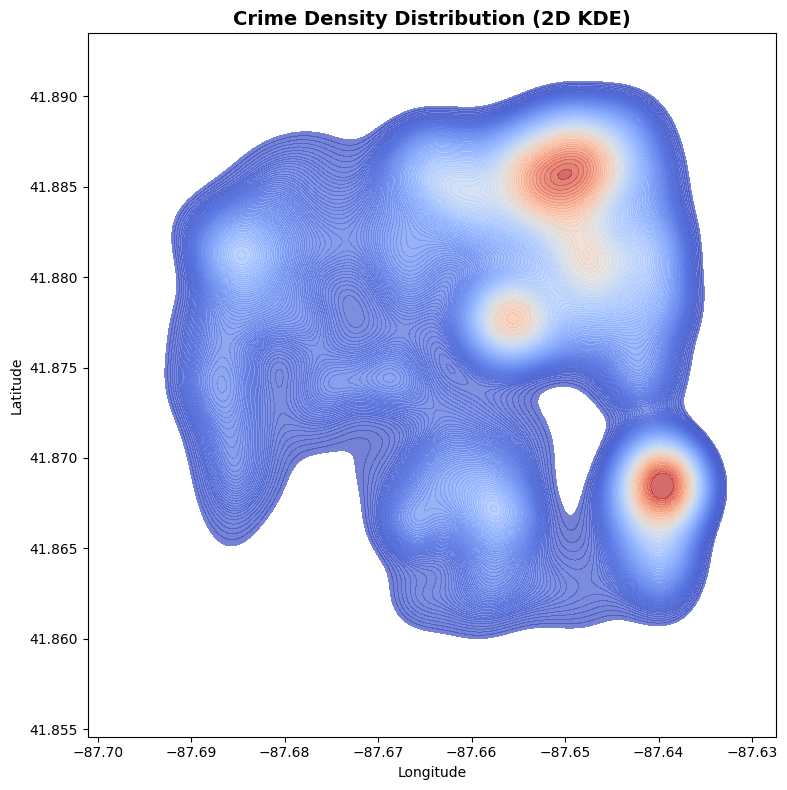

In [107]:
# 2D KDE (Heatmap) to visualize crime density based on geographic coordinates
plt.figure(figsize=(8,8))

sns.kdeplot(
    x=filtered_df['Longitude'],
    y=filtered_df['Latitude'],
    fill=True,
    cmap='coolwarm',
    levels=100,
    alpha=0.7,
    thresh=0.05
)

plt.title('Crime Density Distribution (2D KDE)', fontsize=14, weight='bold')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

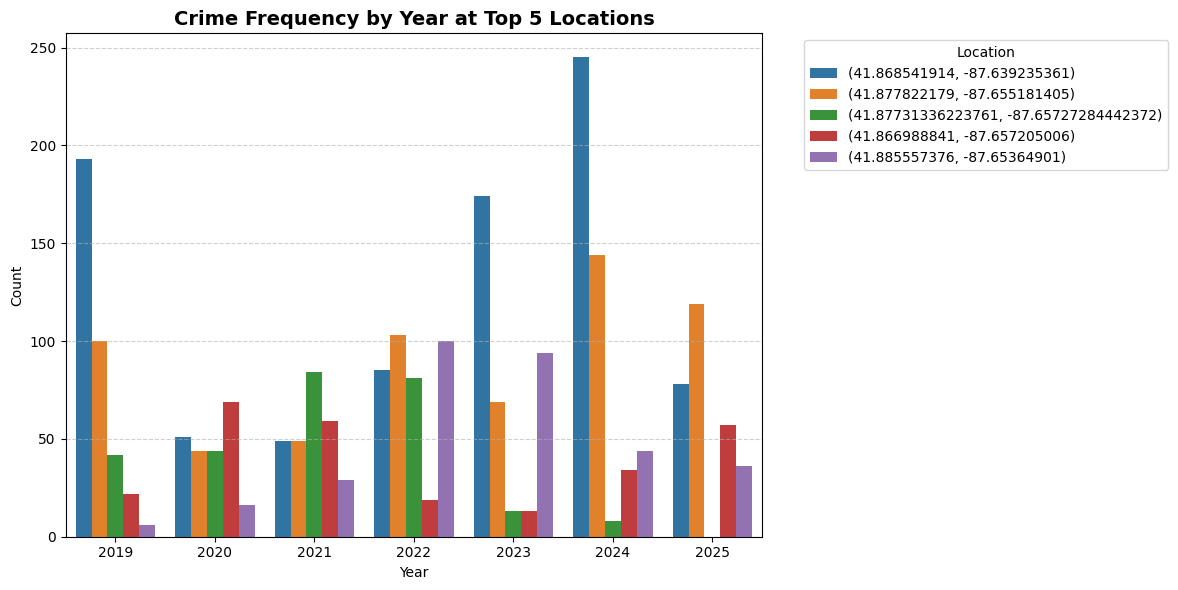

In [108]:
# Select top 5 most frequent crime locations
top_locs = filtered_df['Location'].value_counts().head(5).index


subset = filtered_df[filtered_df['Location'].isin(top_locs)]

plt.figure(figsize=(12,6))


sns.countplot(
    data=subset,
    x='Year',
    hue='Location',
    palette='tab10'
)

plt.title('Crime Frequency by Year at Top 5 Locations', fontsize=14, weight='bold')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

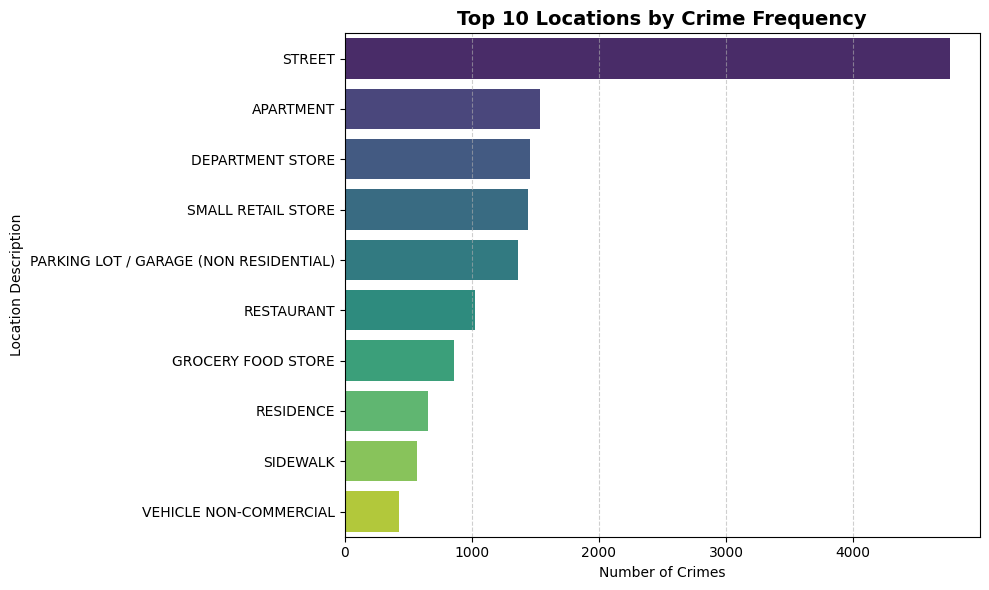

In [109]:
plt.figure(figsize=(10,6))

# Get the top 10 most frequent 'Location Description' entries
top10 = filtered_df['Location Description'].value_counts().head(10)

# Barplot showing frequency of crimes at each of the top 10 locations
sns.barplot(
    y=top10.index,
    x=top10.values,
    palette='viridis'
)

plt.title('Top 10 Locations by Crime Frequency', fontsize=14, weight='bold')
plt.xlabel('Number of Crimes')
plt.ylabel('Location Description')

# Add light horizontal gridlines for better readability
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

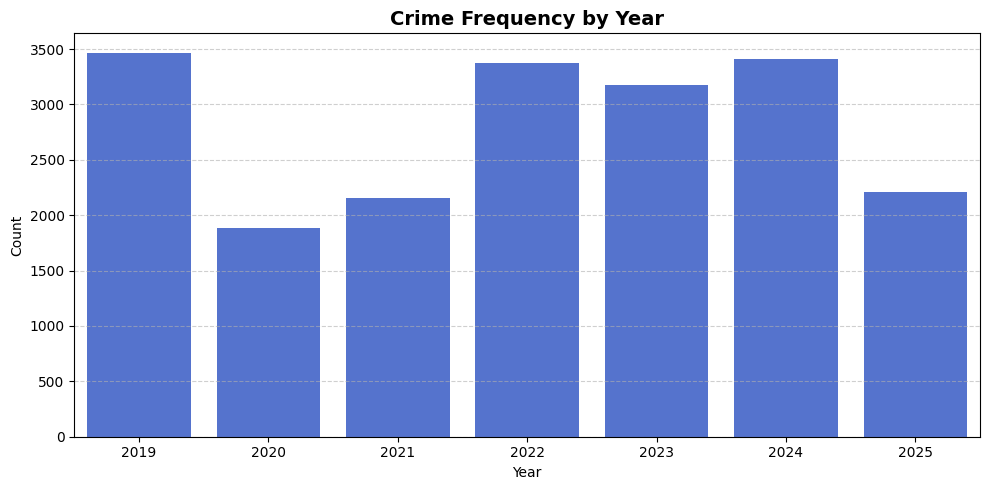

In [110]:
plt.figure(figsize=(10,5))

# Countplot showing the number of crimes for each year
sns.countplot(
    data=filtered_df,
    x='Year',
    color='royalblue'
)

plt.title('Crime Frequency by Year', fontsize=14, weight='bold')
plt.xlabel('Year')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

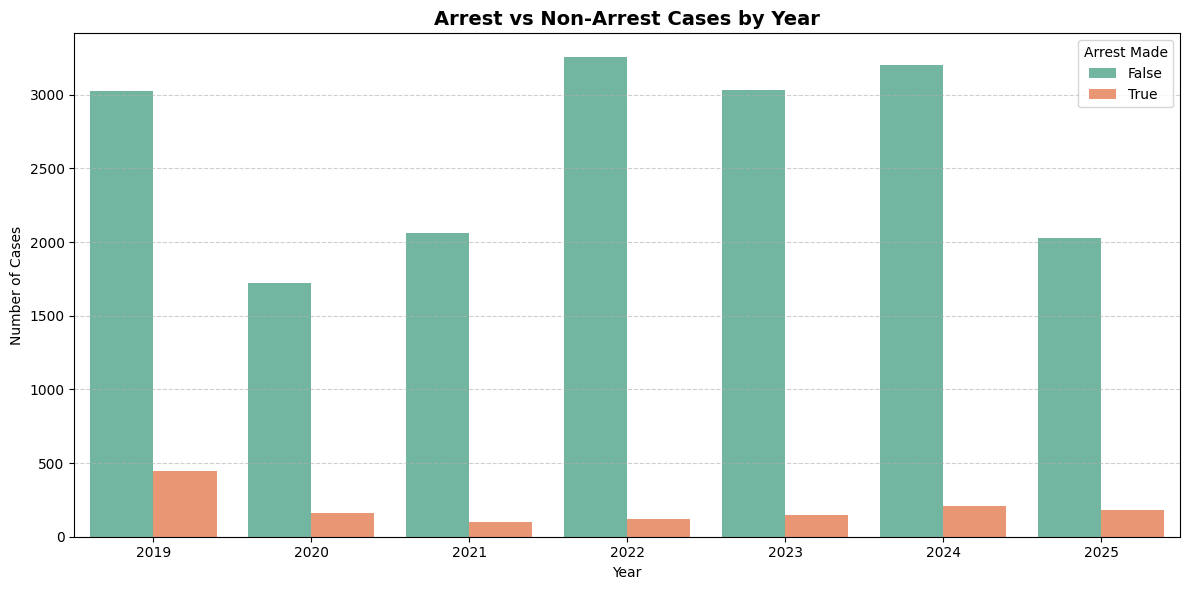

In [111]:
plt.figure(figsize=(12,6))

# Countplot showing how many cases resulted in Arrest vs No-Arrest for each year
sns.countplot(
    data=filtered_df,
    x='Year',
    hue='Arrest',
    palette='Set2'
)

plt.title('Arrest vs Non-Arrest Cases by Year', fontsize=14, weight='bold')
plt.xlabel('Year')
plt.ylabel('Number of Cases')

# Legend labeling Arrest = True/False
plt.legend(title='Arrest Made')
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


### 3.1.1. FEATURE ENGINEERING AND PREPROCESIING(CRIME DATA)

In [112]:
import holidays
filtered_df['crime_count'] = 1   # each row represents one crime event

# 1. Daily aggregation
daily_df = filtered_df.resample('D').agg({
    'crime_count': 'count',    # total number of crimes per day
    'Arrest': 'sum',           # number of arrests per day
    'District': 'nunique'
})

# 2. Time-based features
daily_df['day_of_week'] = daily_df.index.dayofweek   # extract weekday (0=Mon, 6=Sun)
daily_df['is_weekend'] = daily_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)   # weekend flag

# 3. Holiday indicator (US holidays)
us_holidays = holidays.UnitedStates()   # load US public holidays
daily_df['is_holiday'] = daily_df.index.to_series().apply(lambda x: 1 if x in us_holidays else 0)   # flag holidays

# 4. Group-based averages
daily_df['weekday_avg'] = (
    daily_df.groupby(daily_df.index.dayofweek)['crime_count']
    .transform(lambda x: x.shift(1).expanding().mean())   # cumulative mean by weekday
)

daily_df['month_avg'] = (
    daily_df.groupby(daily_df.index.month)['crime_count']
    .transform(lambda x: x.shift(1).expanding().mean())   # cumulative mean by month
)

daily_df['weekend_avg'] = (
    daily_df.groupby(daily_df.index.dayofweek)['crime_count']
    .transform(lambda x: x.shift(1).expanding().mean())   # weekend mean
)
daily_df.loc[daily_df['is_weekend'] == 0, 'weekend_avg'] = 0   # only weekends retain avg

daily_df[['weekday_avg', 'month_avg', 'weekend_avg']] = (
    daily_df[['weekday_avg', 'month_avg', 'weekend_avg']].fillna(method="bfill")   # fill missing values
)

# Add lag features
daily_df['lag_1'] = daily_df['crime_count'].shift(1)    # previous day crime count
daily_df['lag_7'] = daily_df['crime_count'].shift(7)    # last week's same-day count
daily_df = daily_df.dropna()

# daily_df is now ready for multivariate time series modeling
daily_df   # final dataset


,crime_count,Arrest,District,day_of_week,is_weekend,is_holiday,weekday_avg,month_avg,weekend_avg,lag_1,lag_7
Date,,,,,,,,,,,
2019-01-08,12,1,3,1,0,0,2.000000,7.857143,0.000000,12.0,2.0
2019-01-09,10,0,3,2,0,0,9.000000,8.375000,0.000000,12.0,9.0
2019-01-10,12,3,2,3,0,0,8.000000,8.555556,0.000000,10.0,8.0
2019-01-11,14,1,2,4,0,0,9.000000,8.900000,0.000000,12.0,9.0
2019-01-12,7,2,2,5,1,0,9.000000,9.363636,9.000000,14.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...
2025-09-16,6,1,2,1,0,0,7.880000,9.056410,0.000000,16.0,7.0
2025-09-17,6,0,1,2,0,0,8.114286,9.040816,0.000000,6.0,13.0
2025-09-18,5,0,3,3,0,0,8.260000,9.025381,0.000000,6.0,10.0


### 3.2 WEATHER Data



In [113]:
weather_df = weather[['Local time in Chicago / Midway (airport)', 'T',  'U', 'Ff']]   # required weather columns
weather_df.columns = ['datetime', 'temperature', 'humidity', 'wind_speed']   # renaming columns for clarity


In [114]:
weather_df

,datetime,temperature,humidity,wind_speed
0,20.09.2025 22:00,22.2,82.0,2.0
1,20.09.2025 16:00,25.6,60.0,0.0
2,20.09.2025 10:00,23.3,69.0,0.0
3,20.09.2025 04:00,22.2,68.0,5.0
4,19.09.2025 22:00,26.1,52.0,2.0
...,...,...,...,...
9859,02.01.2019 03:00,-2.2,88.0,2.0
9860,01.01.2019 21:00,-2.2,85.0,3.0
9861,01.01.2019 15:00,-1.7,85.0,4.0
9862,01.01.2019 09:00,-0.6,85.0,4.0


### 3.2.1 EDA (WEATHER DATA)

In [115]:
tempdf = weather_df.copy()
tempdf['datetime'] = pd.to_datetime(tempdf['datetime'], format='%d.%m.%Y %H:%M', errors='coerce')   # convert string to datetime format

tempdf['year'] = tempdf['datetime'].dt.year
tempdf['month'] = tempdf['datetime'].dt.month
tempdf['day'] = tempdf['datetime'].dt.day
tempdf['hour'] = tempdf['datetime'].dt.hour


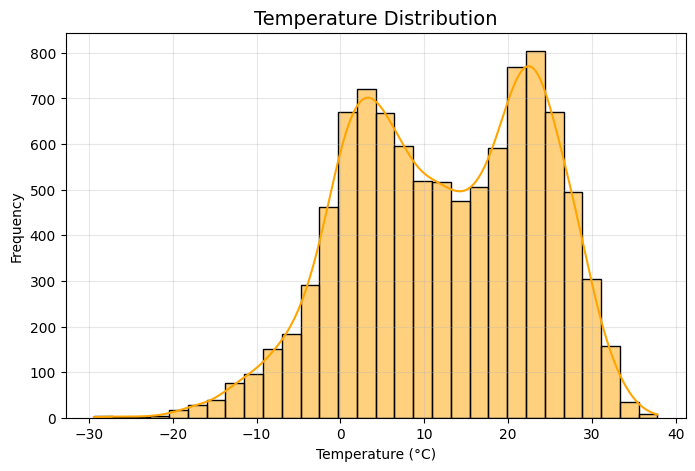

In [116]:
plt.figure(figsize=(8,5))
sns.histplot(tempdf['temperature'], kde=True, bins=30, color='orange')   # plot histogram with KDE for temperature
plt.title('Temperature Distribution', fontsize=14)
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()


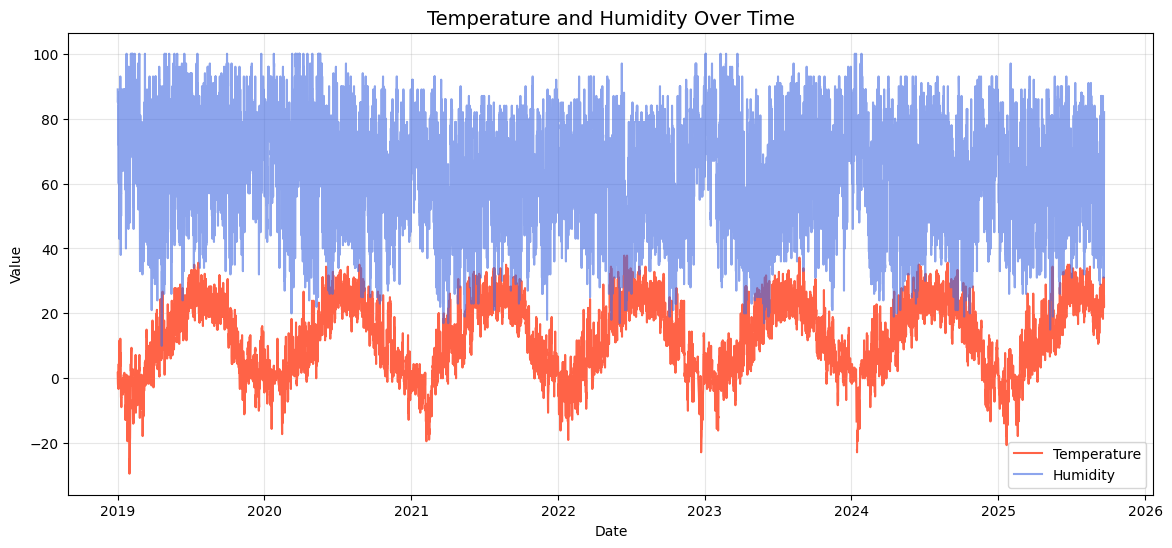

In [117]:
plt.figure(figsize=(14,6))
plt.plot(tempdf['datetime'], tempdf['temperature'], color='tomato', label='Temperature')   # plot temperature over time
plt.plot(tempdf['datetime'], tempdf['humidity'], color='royalblue', label='Humidity', alpha=0.6)   # plot humidity over time
plt.title('Temperature and Humidity Over Time', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


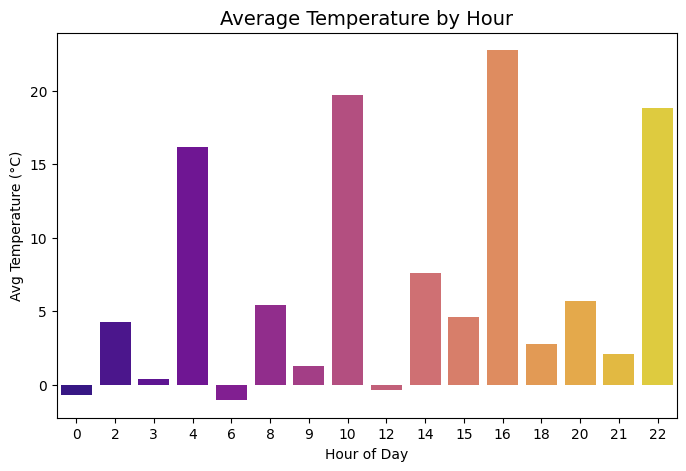

In [118]:
hourly_temp = tempdf.groupby('hour')['temperature'].mean().reset_index()   # compute avg temperature for each hour of the day
plt.figure(figsize=(8,5))   # create figure for bar plot
sns.barplot(x='hour', y='temperature', data=hourly_temp, palette='plasma')   # bar plot of hourly average temperature
plt.title('Average Temperature by Hour', fontsize=14)
plt.xlabel('Hour of Day')
plt.ylabel('Avg Temperature (°C)')
plt.show()


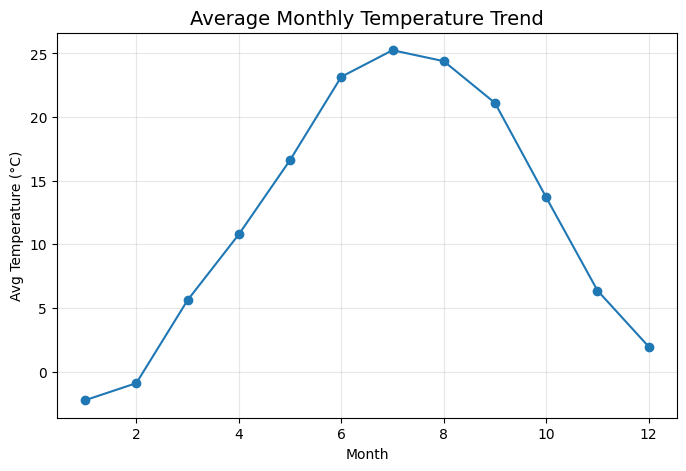

In [119]:
monthly_temp = tempdf.groupby('month')['temperature'].mean().reset_index()  # compute avg temp per month
plt.figure(figsize=(8,5))
plt.plot(monthly_temp['month'], monthly_temp['temperature'], marker='o')
plt.title('Average Monthly Temperature Trend', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Avg Temperature (°C)')
plt.grid(alpha=0.3)
plt.show()


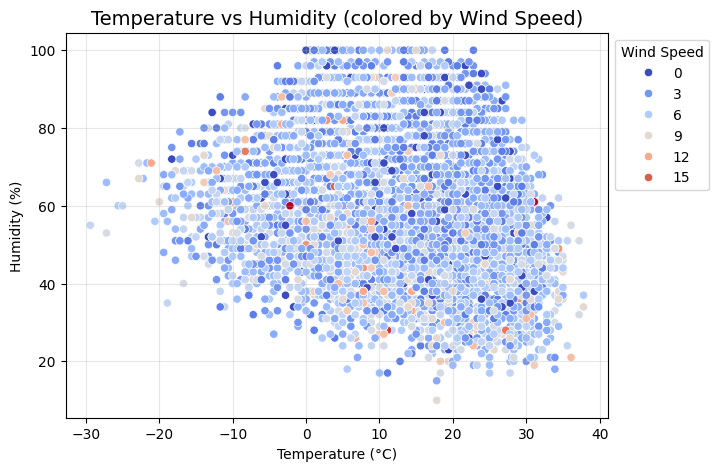

In [120]:
plt.figure(figsize=(7,5))
sns.scatterplot(x='temperature', y='humidity', data=tempdf, hue='wind_speed', palette='coolwarm')  # scatter plot with color by wind speed
plt.title('Temperature vs Humidity (colored by Wind Speed)', fontsize=14)
plt.xlabel('Temperature (°C)')
plt.ylabel('Humidity (%)')
plt.legend(title='Wind Speed', bbox_to_anchor=(1,1))
plt.grid(alpha=0.3)
plt.show()


### 3.2.2 FEATURE ENGINEERING AND PREPROCESSING

In [121]:
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'], dayfirst=True)  # convert to datetime format (day first)
weather_df.set_index('datetime', inplace=True)  # set datetime as index
weather_df = weather_df.sort_index()  # sort rows by datetime index


In [122]:
weather_df['temperature'].interpolate(method='time', inplace=True)  # interpolate missing temperature based on time
weather_df['humidity'].interpolate(method='time', inplace=True)     # interpolate missing humidity based on time
weather_df['wind_speed'].fillna(0, inplace=True)                    # replace missing wind speed with 0


In [123]:
daily_weather = weather_df.resample('D').agg({
    'temperature': 'mean',
    'humidity': 'mean',
    'wind_speed': 'mean'
})


In [124]:
# Discomfort Index (DI) calculation using temperature + humidity formula
daily_weather['DI'] = 0.5 * (
    daily_weather['temperature'] + 61 +
    ((daily_weather['temperature'] - 68) * 1.2) +
    (daily_weather['humidity'] * 0.094)
)  # compute final DI value

daily_weather  # updated dataframe


,temperature,humidity,wind_speed,DI
datetime,,,,
2019-01-01,-0.700,86.00,3.75,-7.02800
2019-01-02,-1.125,80.25,4.50,-7.76575
2019-01-03,0.150,75.75,5.50,-6.57475
2019-01-04,3.240,72.40,4.00,-3.33320
2019-01-05,5.580,74.80,3.60,-0.64640
...,...,...,...,...
2025-09-16,23.900,49.50,3.00,18.31650
2025-09-17,23.475,60.00,1.25,18.34250
2025-09-18,24.025,59.00,2.75,18.90050


### 3.2.3 DATA MERGING

In [125]:
# Merging daily aggregated crime data with daily averaged weather data
merged_df = daily_df.join(daily_weather, how='left')  # left join preserves all crime days

merged_df.interpolate(method="time", inplace=True)  # fill missing weather values using time-based interpolation

In [126]:
merged_df

,crime_count,Arrest,District,day_of_week,is_weekend,is_holiday,weekday_avg,month_avg,weekend_avg,lag_1,lag_7,temperature,humidity,wind_speed,DI
Date,,,,,,,,,,,,,,,
2019-01-08,12,1,3,1,0,0,2.000000,7.857143,0.000000,12.0,2.0,5.627273,70.454545,7.363636,-0.798636
2019-01-09,10,0,3,2,0,0,9.000000,8.375000,0.000000,12.0,9.0,-5.225000,56.375000,8.125000,-13.397875
2019-01-10,12,3,2,3,0,0,8.000000,8.555556,0.000000,10.0,8.0,-6.985714,62.714286,3.142857,-15.036714
2019-01-11,14,1,2,4,0,0,9.000000,8.900000,0.000000,12.0,9.0,-2.685714,71.000000,2.285714,-9.917286
2019-01-12,7,2,2,5,1,0,9.000000,9.363636,9.000000,14.0,9.0,-1.016667,81.666667,5.000000,-7.580000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-16,6,1,2,1,0,0,7.880000,9.056410,0.000000,16.0,7.0,23.900000,49.500000,3.000000,18.316500
2025-09-17,6,0,1,2,0,0,8.114286,9.040816,0.000000,6.0,13.0,23.475000,60.000000,1.250000,18.342500
2025-09-18,5,0,3,3,0,0,8.260000,9.025381,0.000000,6.0,10.0,24.025000,59.000000,2.750000,18.900500


In [127]:
merged_df.nunique()

,0
crime_count,28
Arrest,6
District,5
day_of_week,7
is_weekend,2
is_holiday,2
weekday_avg,2281
month_avg,2123
weekend_avg,681
lag_1,28


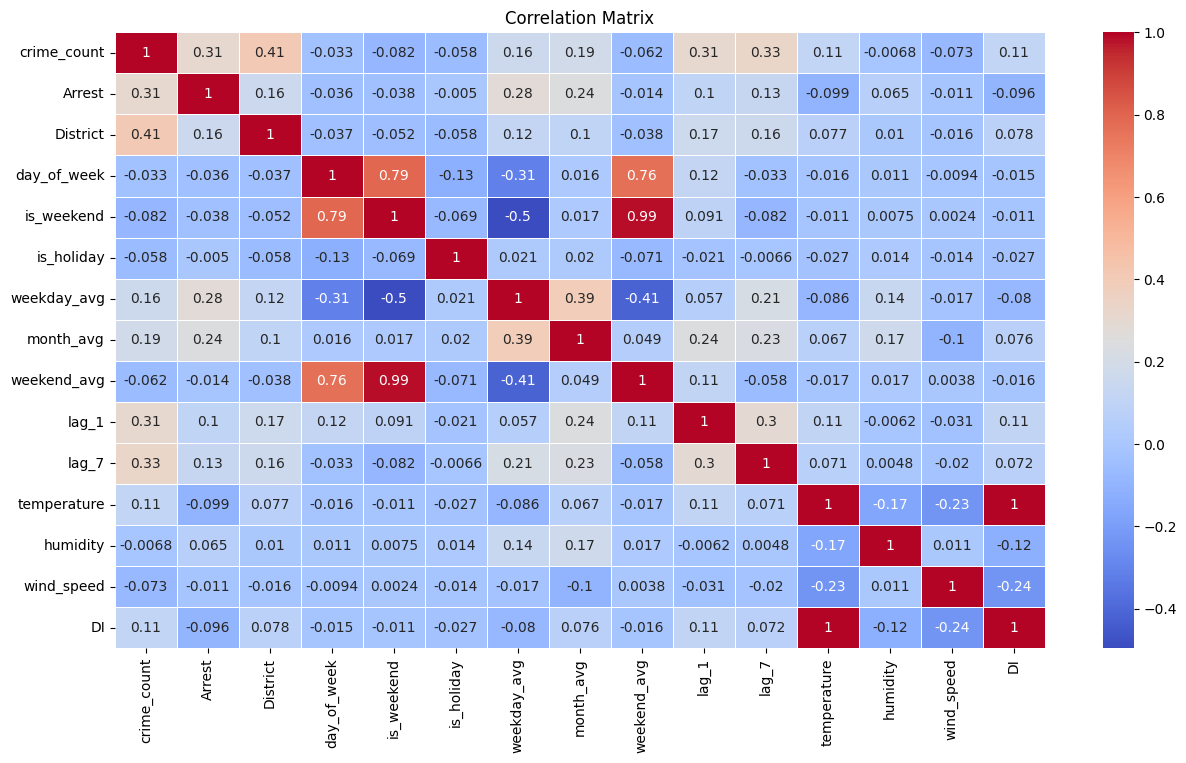

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numerical columns for correlation matrix
numeric_merged_df = merged_df.select_dtypes(include=np.number)   # keep only numeric columns

corr_matrix = numeric_merged_df.corr()
plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [129]:
merged_df.columns

Index(['crime_count', 'Arrest', 'District', 'day_of_week', 'is_weekend',
       'is_holiday', 'weekday_avg', 'month_avg', 'weekend_avg', 'lag_1',
       'lag_7', 'temperature', 'humidity', 'wind_speed', 'DI'],
      dtype='object')

In [130]:
from sklearn.preprocessing import StandardScaler
final_df = merged_df.copy()
# Choose the feature columns you want to feed to models
feature_cols = ['crime_count', 'Arrest', 'District', 'day_of_week', 'is_weekend',
       'is_holiday', 'weekday_avg', 'month_avg', 'weekend_avg', 'lag_1',
       'lag_7', 'temperature', 'humidity', 'wind_speed', 'DI']

target_col = 'crime_count'

# Safety check: ensure columns exist
for c in feature_cols + [target_col]:
    assert c in merged_df.columns, f"Missing column: {c}"

# Train/test split (time-wise) BEFORE scaling
n_total = len(daily_df)
split_row = int(0.8 * n_total)
train_df = merged_df.iloc[:split_row].copy()
test_df  = merged_df.iloc[split_row:].copy()

# Fit scalers on train only
feature_scaler = StandardScaler().fit(train_df[feature_cols].values)
target_scaler  = StandardScaler().fit(train_df[[target_col]].values)

# Apply the scaler to the whole dataset
features_scaled = feature_scaler.transform(merged_df[feature_cols].values)
target_scaled   = target_scaler.transform(merged_df[[target_col]].values)

In [131]:

WINDOW_SIZE = 7
def create_rolling_windows_from_scaled(features_arr, target_arr, window_size=WINDOW_SIZE):
    X, y = [], []
    for i in range(len(features_arr) - window_size):
        X.append(features_arr[i:i+window_size])
        y.append(target_arr[i+window_size])   # next day target
    X = np.array(X)   # (n_samples, window_size, n_features)
    y = np.array(y)   # (n_samples, 1)
    return X, y

X_all, y_all = create_rolling_windows_from_scaled(features_scaled, target_scaled, window_size=WINDOW_SIZE)


In [132]:
n_samples = X_all.shape[0]
split_sample = int(0.8 * n_samples) # 80% split index

X_train, X_test = X_all[:split_sample], X_all[split_sample:] # split features
y_train, y_test = y_all[:split_sample], y_all[split_sample:] # split labels

print("X_train.shape:", X_train.shape, "X_test.shape:", X_test.shape)
print("y_train.shape:", y_train.shape, "y_test.shape:", y_test.shape)


X_train.shape: (1952, 7, 15) X_test.shape: (489, 7, 15)
y_train.shape: (1952, 1) y_test.shape: (489, 1)


In [133]:

early_stop = EarlyStopping( # stop training early if val_loss doesn't improve
monitor='val_loss',
patience=5, # wait 5 epochs before stopping
restore_best_weights=True, # restore best model weights
verbose=1
)

lr_reduce = ReduceLROnPlateau( # reduce learning rate when val_loss plateaus
monitor='val_loss',
factor=0.5, # reduce LR by factor of 0.5
patience=2, # wait 2 epochs before reducing LR
verbose=1
)

## 4. Model Implementation & Evalation

### 1.)LSTM

In [134]:

model = Sequential([ # define sequential model
    Input(shape=(X_train.shape[1], X_train.shape[2])),  # Input layer specifying time steps and features (1 feature here)
    LSTM(128, activation="relu", return_sequences=False),  # LSTM layer with 128 units, outputs last timestep only
    Dropout(0.7), # Dropout
    Flatten(),
    Dense(64, activation='relu'), # Dense layer with 64 neurons and ReLU activation
    Dropout(0.7),
    Dense(64, activation='relu'),
    Dropout(0.7),
    Dense(64, activation="relu"),       # Fully connected hidden layer with 64 neurons and ReLU activation
    Dense(32, activation="relu"),       # Another Dense layer with 32 neurons and ReLU
    Dense(1, activation="linear")       # Output layer with 1 neuron for regression (linear activation)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae']) # compile model for regression task


In [135]:
history = model.fit(  # train the LSTM model
    X_train, y_train,  # training data
    validation_data=(X_test, y_test),  # validation data
    epochs=50,  # number of epochs
    batch_size=64,  # batch size
    verbose=1,  # print progress
    callbacks=[early_stop, lr_reduce]  # callbacks for early stopping and learning rate reduction
)


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 1.0469 - mae: 0.8258 - val_loss: 0.8951 - val_mae: 0.7291 - learning_rate: 0.0010
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.9946 - mae: 0.7865 - val_loss: 0.8908 - val_mae: 0.7283 - learning_rate: 0.0010
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.9470 - mae: 0.7871 - val_loss: 0.9263 - val_mae: 0.7410 - learning_rate: 0.0010
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9830 - mae: 0.7879
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.9826 - mae: 0.7876 - val_loss: 0.9321 - val_mae: 0.7430 - learning_rate: 0.0010
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.9596 - mae: 0.7708 - val_loss: 0.9186 - val_mae: 0.7383 - learning_rate: 5.0000e-04
Epoch 6/50
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9716 - mae: 0.7966
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00025000001

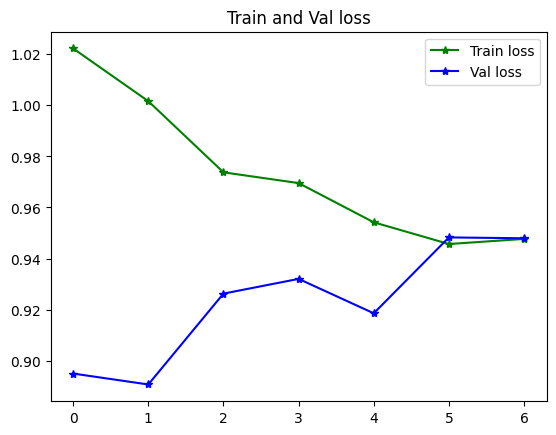

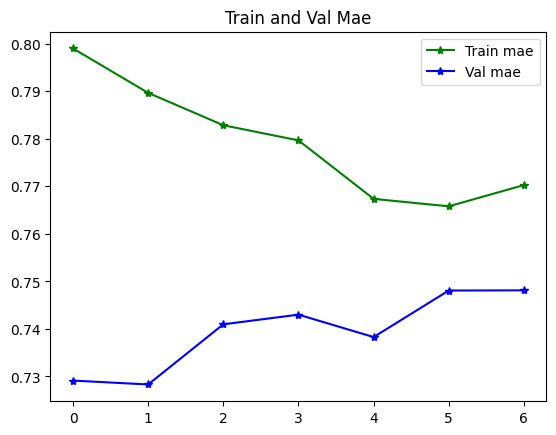

In [136]:
plt.plot(history.history['loss'], 'g', marker='*', label='Train loss')  # plot training loss
plt.plot(history.history['val_loss'], 'b', marker='*', label='Val loss')  # plot validation loss
plt.title('Train and Val loss')
plt.legend()
plt.figure()
plt.plot(history.history['mae'], 'g', marker='*', label='Train mae')  # plot training MAE
plt.plot(history.history['val_mae'], 'b', marker='*', label='Val mae')  # plot validation MAE
plt.title('Train and Val Mae')
plt.legend()
plt.show()


In [137]:
start_exec = time.time()  # start measuring execution time

predicted = model.predict(X_test)  # generate predictions on test set

end_exec = time.time()  # end measuring execution time
execution_time = end_exec - start_exec  # total execution time

print('Mean Squared Error(MSE):', metrics.mean_squared_error(y_test, predicted))  # MSE
print('Root Mean Squared Error(RMSE):', np.sqrt(metrics.mean_squared_error(y_test, predicted)))  # RMSE

# print('R-squared(R2-Score):', metrics.r2_score(y_test, predicted))  # R2 score (optional)
print('Mean Absolute Error(MAE):', metrics.mean_absolute_error(y_test, predicted))  # MAE

predicted_value = target_scaler.inverse_transform(predicted)  # inverse scale predicted values
real_value = target_scaler.inverse_transform(y_test.reshape(-1, 1))  # inverse scale true values

actualpred_df = pd.DataFrame({  # create dataframe comparing real vs predicted
    "Real": real_value.ravel(),
    "Predicted": predicted_value.ravel()
}, index = final_df.index[-len(real_value):])
print(actualpred_df.tail())

start = time.time()  # start latency measurement
for i in range(min(1000, len(X_test))):
    _ = model.predict(X_test[i].reshape(1, X_test.shape[1], X_test.shape[2]), verbose=0)  # predict single sample
end = time.time()
latency = (end - start) / min(1000, len(X_test))  # average latency per prediction

start = time.time()  # start throughput measurement
_ = model.predict(X_test)  # predict entire test set
end = time.time()
throughput = len(X_test) / (end - start)  # predictions per second

print(f"\nLatency per prediction: {latency * 1000:.4f} ms")
print(f"Throughput: {throughput:.2f} predictions/sec")

print(f"Total Execution Time: {execution_time:.4f} seconds")  # total model execution time

process = psutil.Process(os.getpid())  # get current process info
memory_usage = process.memory_info().rss / (1024 ** 2)  # memory usage in MB
print(f"Memory Usage: {memory_usage:.2f} MB")


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Mean Squared Error(MSE): 0.8907984818048135
Root Mean Squared Error(RMSE): 0.9438212128389643
Mean Absolute Error(MAE): 0.7283095924938959
            Real  Predicted
Date                       
2025-09-16   6.0   7.721508
2025-09-17   6.0   7.723653
2025-09-18   5.0   7.692736
2025-09-19   7.0   7.673212
2025-09-20   6.0   7.621661
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Latency per prediction: 96.9529 ms
Throughput: 2963.86 predictions/sec
Total Execution Time: 0.7826 seconds
Memory Usage: 2643.50 MB


In [138]:

fig = px.line(actualpred_df.reset_index(), x=actualpred_df.index, y=actualpred_df.columns, title='Actual vs Predicted')  # create line plot comparing actual vs predicted values
fig.show()


## LSTM FORECASTING

In [139]:


last_window = features_scaled[-WINDOW_SIZE:].copy()  # copy last WINDOW_SIZE rows to start forecasting

future_predictions = []  # crime counts
future_dates = []        # future dates

# last date in the historical dataset
last_date = merged_df.index[-1]

# Iteratively predict the next 7 days
current_window = last_window.copy()  # start with last known window
start_exec = time.time()  # track execution time
for i in range(7):
    # Predict next day using current window
    pred_scaled = model.predict(current_window[np.newaxis, :, :], verbose=0)  # predict (1, WINDOW_SIZE, n_features)

    # Inverse transform to get original scale
    future_pred = target_scaler.inverse_transform(pred_scaled)[0][0]
    future_predictions.append(future_pred)  # store prediction

    # Generate the date for the predicted day
    next_date = last_date + timedelta(days=i+1)
    future_dates.append(next_date)

    # Update the window: replace target with predicted value
    next_features = current_window[-1].copy()  # start with last day’s features
    next_features[feature_cols.index('crime_count')] = pred_scaled  # update target feature

    # Roll window forward
    current_window = np.vstack([current_window[1:], next_features])
end_exec = time.time()
execution_time = end_exec - start_exec

# Create forecast dataframe with predicted values
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Crime_Count': future_predictions
})
forecast_df.set_index('Date', inplace=True)  # set Date as index
print(f"Total Execution Time for forecasting: {execution_time:.4f} seconds")
print("\n 7-Day Crime Forecast:")
forecast_df


Total Execution Time for forecasting: 0.6332 seconds

 7-Day Crime Forecast:


,Predicted_Crime_Count
Date,
2025-09-21,7.589120
2025-09-22,7.554476
2025-09-23,7.566274
2025-09-24,7.573555
2025-09-25,7.571429
2025-09-26,7.572967
2025-09-27,7.567365


In [140]:
fig = px.line(forecast_df.reset_index(), x='Date', y='Predicted_Crime_Count', title='7-Day Crime Forecast')
fig.show()

### 2.) BiLSTM

In [141]:
# Bidirectional GRU/LSTM model for time series forecasting
model = Sequential([
    Bidirectional(LSTM(units=128, return_sequences=True,  # First Bi-LSTM layer with 128 units
                       input_shape=(X_train.shape[1], X_train.shape[2]))),
    Dropout(0.7),  # Dropout to prevent overfitting

    Bidirectional(LSTM(units=64, return_sequences=False)),  # Second Bi-LSTM layer with 64 units
    Dropout(0.7),
    Flatten(),  # Flatten the output to feed into dense layers

    Dense(64, activation='relu'),  # Dense layer with 64 neurons and ReLU
    Dropout(0.7),  # Dropout for regularization
    Dense(64, activation='relu'),  # Another dense layer with 64 neurons
    Dropout(0.7),

    Dense(1)  # Output layer with 1 neuron for regression
])

model.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))  # model with proper input shape
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_10                │ (None, 7, 256)         │       147,456 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 7, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 324,289 (1.24 MB)

 Trainable params: 324,289 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

In [142]:
# Model compilation
model.compile(optimizer='adam', loss='mse',metrics=['mae'])

In [143]:
# Train the Bidirectional LSTM model with early stopping and learning rate reduction
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    verbose=1,
    callbacks=[early_stop, lr_reduce]  # Early stopping & LR scheduler
)


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - loss: 1.1659 - mae: 0.8587 - val_loss: 0.8303 - val_mae: 0.7065 - learning_rate: 0.0010
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.9404 - mae: 0.7671 - val_loss: 0.8164 - val_mae: 0.7018 - learning_rate: 0.0010
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.9087 - mae: 0.7519 - val_loss: 0.7775 - val_mae: 0.6883 - learning_rate: 0.0010
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.8917 - mae: 0.7472 - val_loss: 0.7802 - val_mae: 0.6894 - learning_rate: 0.0010
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.9649 - mae: 0.7525
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.9630 - mae: 0.7521 - val_loss: 0.8123 - val_mae: 0.6988 - learning_rate: 0.0010
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.9019 - mae: 0.7444 - val_loss: 0.8065 - val_mae: 0.6976 - learning_rate: 5.0000e-04
Epoc

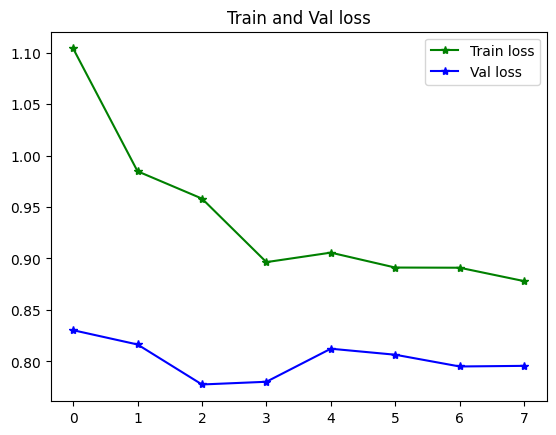

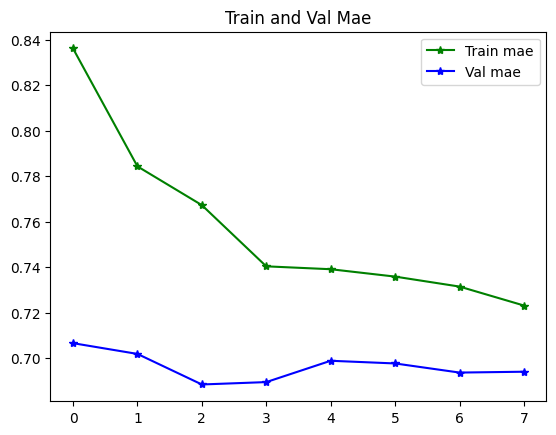

In [144]:
#Train and Validation Accuracy
plt.plot(history.history['loss'], 'g', marker='*', label='Train loss')
plt.plot(history.history['val_loss'], 'b', marker='*', label='Val loss')
plt.title('Train and Val loss')
plt.legend()
plt.figure()
#Train and Validation Loss
plt.plot(history.history['mae'], 'g', marker='*', label='Train mae')
plt.plot(history.history['val_mae'], 'b', marker='*', label='Val mae')
plt.title('Train and Val Mae')
plt.legend()
plt.show()


In [145]:
# Start measuring execution time for model prediction
start_exec = time.time()

# Predict on test data
predicted = model.predict(X_test)

# End execution timer
end_exec = time.time()
execution_time = end_exec - start_exec  # Total execution time

# Calculate and print performance metrics
print('Mean Squared Error(MSE):', metrics.mean_squared_error(y_test, predicted))  # MSE
print('Root Mean Squared Error(RMSE):', np.sqrt(metrics.mean_squared_error(y_test, predicted)))  # RMSE
# print('R-squared(R2-Score):', metrics.r2_score(y_test, predicted))  # R2
print('Mean Absolute Error(MAE):', metrics.mean_absolute_error(y_test, predicted))  # MAE

# Inverse transform predictions and true values to original scale
predicted_value = target_scaler.inverse_transform(predicted)  # Predicted in original scale
real_value = target_scaler.inverse_transform(y_test.reshape(-1, 1))  # Actual values in original scale

# Create DataFrame for comparison
actualpred_df = pd.DataFrame({
    "Real": real_value.ravel(),
    "Predicted": predicted_value.ravel()
}, index = final_df.index[-len(real_value):])
print(actualpred_df.tail())

# Measure latency per prediction
start = time.time()
for i in range(min(1000, len(X_test))):
    _ = model.predict(X_test[i].reshape(1, X_test.shape[1], X_test.shape[2]), verbose=0)  # Predict single instance
end = time.time()
latency = (end - start) / min(1000, len(X_test))  # Average latency per prediction

# Measure throughput for batch predictions
start = time.time()
_ = model.predict(X_test)
end = time.time()
throughput = len(X_test) / (end - start)  # Predictions per second

# Print latency and throughput
print(f"\nLatency per prediction: {latency * 1000:.4f} ms")  # Convert to ms
print(f"Throughput: {throughput:.2f} predictions/sec")  # Predictions/sec

# Print total execution time
print(f"Total Execution Time: {execution_time:.4f} seconds")  # Total time

# Measure memory usage
process = psutil.Process(os.getpid())  # Current process
memory_usage = process.memory_info().rss / (1024 ** 2)  # Memory in MB
print(f"Memory Usage: {memory_usage:.2f} MB")


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step
Mean Squared Error(MSE): 0.7775399589073877
Root Mean Squared Error(RMSE): 0.8817822627538998
Mean Absolute Error(MAE): 0.6883308962330393
            Real  Predicted
Date                       
2025-09-16   6.0   8.153402
2025-09-17   6.0   8.421783
2025-09-18   5.0   8.497120
2025-09-19   7.0   8.354998
2025-09-20   6.0   8.170811
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Latency per prediction: 110.0369 ms
Throughput: 1646.03 predictions/sec
Total Execution Time: 3.0906 seconds
Memory Usage: 2625.96 MB


In [146]:
fig = px.line(actualpred_df.reset_index(), x=actualpred_df.index, y=actualpred_df.columns, title='Actual vs Predicted')
fig.show()

## BILSTM FORECASTING

In [147]:

last_window = features_scaled[-WINDOW_SIZE:].copy()  # copy last WINDOW_SIZE rows to start forecasting

future_predictions = []  # list to store predicted crime counts
future_dates = []        # list to store future dates

# Get the last date in the historical dataset
last_date = merged_df.index[-1]

# Iteratively predict the next 7 days
current_window = last_window.copy()  # start with last known window
start_exec = time.time()  # track execution time
for i in range(7):
    # Predict next day using current window
    pred_scaled = model.predict(current_window[np.newaxis, :, :], verbose=0)  # predict (1, WINDOW_SIZE, n_features)

    # Inverse transform to get original scale
    future_pred = target_scaler.inverse_transform(pred_scaled)[0][0]
    future_predictions.append(future_pred)  # store prediction

    # Generate the date for the predicted day
    next_date = last_date + timedelta(days=i+1)
    future_dates.append(next_date)

    # Update the window: replace target with predicted value
    next_features = current_window[-1].copy()  # start with last day’s features
    next_features[feature_cols.index('crime_count')] = pred_scaled  # update target feature

    # Roll window forward
    current_window = np.vstack([current_window[1:], next_features])
end_exec = time.time()  # end timing
execution_time = end_exec - start_exec

# Create forecast dataframe with predicted values
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Crime_Count': future_predictions
})
forecast_df.set_index('Date', inplace=True)  # set Date as index
print(f"Total Execution Time for forecasting: {execution_time:.4f} seconds")
print("\n 7-Day Crime Forecast:")
forecast_df


Total Execution Time for forecasting: 0.7395 seconds

 7-Day Crime Forecast:


,Predicted_Crime_Count
Date,
2025-09-21,7.968138
2025-09-22,7.706345
2025-09-23,7.487166
2025-09-24,7.487426
2025-09-25,7.560568
2025-09-26,7.635220
2025-09-27,7.782847


In [148]:
fig = px.line(forecast_df.reset_index(), x='Date', y='Predicted_Crime_Count', title='7-Day Crime Forecast')
fig.show()

### 3.) Bidirectional GRU

In [149]:
#  GRU (Bidirectional) Model for Time Series Forecasting

def build_gru_model(window_size, n_features):
    model = Sequential()

    # First bidirectional GRU layer, returns sequences for stacking
    model.add(Bidirectional(GRU(64, return_sequences=True), input_shape=(window_size, n_features)))
    model.add(Dropout(0.3))

    # Second bidirectional GRU layer, outputs last timestep only
    model.add(Bidirectional(GRU(64, return_sequences=False)))
    model.add(Dropout(0.3))

    # Output layer: single neuron for regression
    model.add(Dense(1))

    # Compile model with Adam optimizer, mean squared error loss, and MAE metric
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

# Build model instance
model = build_gru_model(WINDOW_SIZE, X_train.shape[2])
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_12                │ (None, 7, 128)         │        31,104 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 128)            │        74,496 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,729 (413.00 KB)

 Trainable params: 105,729 (413.00 KB)

 Non-trainable params: 0 (0.00 B)

In [150]:
# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=64,
    verbose=1,
    callbacks=[early_stop, lr_reduce]
)

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - loss: 0.9631 - mae: 0.7616 - val_loss: 0.7454 - val_mae: 0.6909 - learning_rate: 0.0010
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.7485 - mae: 0.6801 - val_loss: 0.7393 - val_mae: 0.6913 - learning_rate: 0.0010
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.7528 - mae: 0.6647 - val_loss: 0.7200 - val_mae: 0.6818 - learning_rate: 0.0010
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.7312 - mae: 0.6621 - val_loss: 0.7351 - val_mae: 0.6869 - learning_rate: 0.0010
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.7215 - mae: 0.6646
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.7216 - mae: 0.6643 - val_loss: 0.7320 - val_mae: 0.6932 - learning_rate: 0.0010
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.7214 - mae: 0.6536 - val_loss: 0.7267 - val_mae: 0.6857 - learning_rate: 5.0000e-04
Epoc

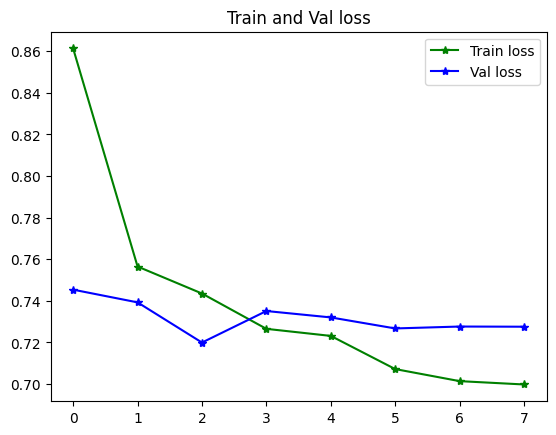

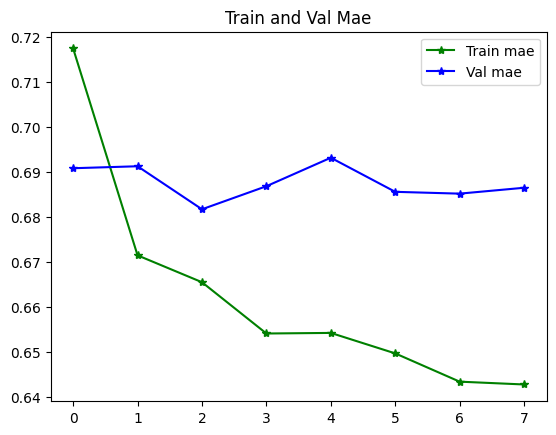

In [151]:
#Train and Validation Accuracy
plt.plot(history.history['loss'], 'g', marker='*', label='Train loss')
plt.plot(history.history['val_loss'], 'b', marker='*', label='Val loss')
plt.title('Train and Val loss')
plt.legend()
plt.figure()
#Train and Validation Loss
plt.plot(history.history['mae'], 'g', marker='*', label='Train mae')
plt.plot(history.history['val_mae'], 'b', marker='*', label='Val mae')
plt.title('Train and Val Mae')
plt.legend()
plt.show()


In [152]:
# Start measuring execution time for model prediction
start_exec = time.time()

# Predict on test data
predicted = model.predict(X_test)  # Model predictions

# End execution timer
end_exec = time.time()  #
execution_time = end_exec - start_exec  # Total execution time

# Calculate and print performance metrics
print('Mean Squared Error(MSE):', metrics.mean_squared_error(y_test, predicted))  # MSE
print('Root Mean Squared Error(RMSE):', np.sqrt(metrics.mean_squared_error(y_test, predicted)))  # RMSE
# print('R-squared(R2-Score):', metrics.r2_score(y_test, predicted))  # R2
print('Mean Absolute Error(MAE):', metrics.mean_absolute_error(y_test, predicted))  # MAE

# Inverse transform predictions and true values to original scale
predicted_value = target_scaler.inverse_transform(predicted)  # Predicted in original scale
real_value = target_scaler.inverse_transform(y_test.reshape(-1, 1))  # Actual values in original scale

# Create DataFrame for comparison
actualpred_df = pd.DataFrame({
    "Real": real_value.ravel(),  # Real values
    "Predicted": predicted_value.ravel()  # Predicted values
}, index = final_df.index[-len(real_value):])
print(actualpred_df.tail())
# Measure latency per prediction
start = time.time()
for i in range(min(1000, len(X_test))):
    _ = model.predict(X_test[i].reshape(1, X_test.shape[1], X_test.shape[2]), verbose=0)  # Predict single instance
end = time.time()
latency = (end - start) / min(1000, len(X_test))  # Average latency per prediction

# Measure throughput for batch predictions
start = time.time()
_ = model.predict(X_test)
end = time.time()
throughput = len(X_test) / (end - start)

# Print latency and throughput
print(f"\nLatency per prediction: {latency * 1000:.4f} ms")
print(f"Throughput: {throughput:.2f} predictions/sec")

# Print total execution time
print(f"Total Execution Time: {execution_time:.4f} seconds")  # Total time

# Measure memory usage
process = psutil.Process(os.getpid())  # Current process
memory_usage = process.memory_info().rss / (1024 ** 2)  # Memory in MB
print(f"Memory Usage: {memory_usage:.2f} MB")

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step
Mean Squared Error(MSE): 0.7199523350578324
Root Mean Squared Error(RMSE): 0.848500050122469
Mean Absolute Error(MAE): 0.6817842371270283
            Real  Predicted
Date                       
2025-09-16   6.0   9.677965
2025-09-17   6.0   9.727408
2025-09-18   5.0   9.691401
2025-09-19   7.0   9.127618
2025-09-20   6.0   8.014772
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Latency per prediction: 103.6782 ms
Throughput: 2261.38 predictions/sec
Total Execution Time: 1.5924 seconds
Memory Usage: 2712.46 MB


In [153]:

fig = px.line(actualpred_df.reset_index(), x=actualpred_df.index, y=actualpred_df.columns, title='Actual vs Predicted ')
fig.show()

## BIGRU FORECASTING

In [154]:


last_window = features_scaled[-WINDOW_SIZE:].copy()  # copy last WINDOW_SIZE rows to start forecasting

future_predictions = []  # predicted crime counts
future_dates = []        #  store future dates


last_date = merged_df.index[-1]

# Iteratively predict the next 7 days
current_window = last_window.copy()  # start with last known window
start_exec = time.time()  # track execution time
for i in range(7):
    # Predict next day using current window
    pred_scaled = model.predict(current_window[np.newaxis, :, :], verbose=0)  # predict (1, WINDOW_SIZE, n_features)

    # Inverse transform to get original scale
    future_pred = target_scaler.inverse_transform(pred_scaled)[0][0]
    future_predictions.append(future_pred)  # store prediction

    # Generate the date for the predicted day
    next_date = last_date + timedelta(days=i+1)
    future_dates.append(next_date)

    # Update the window: replace target with predicted value
    next_features = current_window[-1].copy()  # start with last day’s features
    next_features[feature_cols.index('crime_count')] = pred_scaled  # update target feature

    # Roll window forward
    current_window = np.vstack([current_window[1:], next_features])
end_exec = time.time()
execution_time = end_exec - start_exec

# Create forecast dataframe with predicted values
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Crime_Count': future_predictions
})
forecast_df.set_index('Date', inplace=True)  # set Date as index
print(f"Total Execution Time for forecasting: {execution_time:.4f} seconds")
print("\n 7-Day Crime Forecast:")
forecast_df


Total Execution Time for forecasting: 0.7311 seconds

 7-Day Crime Forecast:


,Predicted_Crime_Count
Date,
2025-09-21,7.576301
2025-09-22,8.139970
2025-09-23,7.887740
2025-09-24,8.043923
2025-09-25,8.393270
2025-09-26,8.617137
2025-09-27,8.538891


In [155]:
fig = px.line(forecast_df.reset_index(), x='Date', y='Predicted_Crime_Count', title='7-Day Crime Forecast')
fig.show()

### 4.) BILSTM WITH ATTENTION

In [156]:

# Cross-Attention Layer Function
def cross_attention_layers(inputs, single_attention_vector=False):
    """
    Applies cross-attention mechanism across time steps.

    Args:
        inputs: Input tensor of shape (batch, timesteps, features)
        single_attention_vector: If True, uses a single attention vector across features

    Returns:
        output_attention_mul: Tensor with attention applied
    """
    time_steps = K.int_shape(inputs)[1]  # Number of timesteps
    input_dim = K.int_shape(inputs)[2]   # Number of features

    # Permute to shape (batch, features, timesteps) for dense layer
    a = Permute((2, 1))(inputs)

    # Softmax over time steps
    a = Dense(time_steps, activation='softmax')(a)

    # Optionally reduce to single attention vector
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1))(a)  # average across features
        a = RepeatVector(input_dim)(a)              # repeat for all features

    # Permute back to (batch, timesteps, features)
    a_probs = Permute((2, 1))(a)

    # Apply attention: element-wise multiplication
    output_attention_mul = Multiply()([inputs, a_probs])

    return output_attention_mul


In [157]:
# Model input shape
INPUT_DIMS = X_train.shape[1]
TIME_STEPS = 1 # This variable seems unused in the model definition.
lstm_units = 128

# Build the Model
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
# First LSTM layer
x = Bidirectional(LSTM(lstm_units, return_sequences=True))(inputs)
x = Dropout(0.3)(x)
# Second LSTM layer
x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
x = Dropout(0.3)(x)
# Attention layer
attention_mul = cross_attention_layers(x)  # Cross Attention mechanism
attention_mul = Flatten()(attention_mul)
# Output layer
output = Dense(1)(attention_mul)

# Define the model
model = Model(inputs=[inputs], outputs=output)

In [158]:
# Model compilation
model.compile(optimizer='adam', loss='mse',metrics=['mae'])

In [159]:
# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=64,
    verbose=1,
    callbacks=[early_stop, lr_reduce]
)

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - loss: 0.9255 - mae: 0.7395 - val_loss: 0.7315 - val_mae: 0.6782 - learning_rate: 0.0010
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 0.7407 - mae: 0.6820 - val_loss: 0.7226 - val_mae: 0.6805 - learning_rate: 0.0010
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.7780 - mae: 0.6670 - val_loss: 0.7422 - val_mae: 0.6940 - learning_rate: 0.0010
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.7227 - mae: 0.6487
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.7223 - mae: 0.6487 - val_loss: 0.7454 - val_mae: 0.6849 - learning_rate: 0.0010
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.6763 - mae: 0.6393 - val_loss: 0.7375 - val_mae: 0.6882 - learning_rate: 5.0000e-04
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.6320 - mae: 0.6208
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00025000

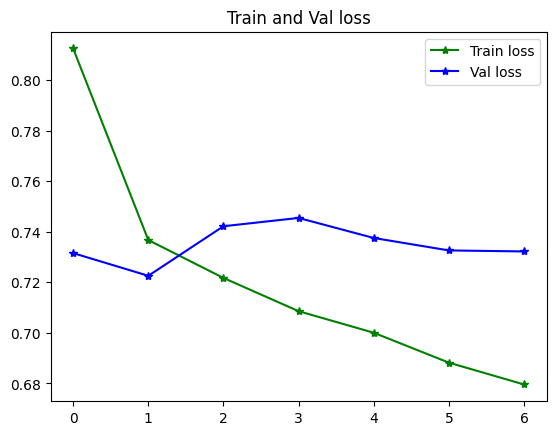

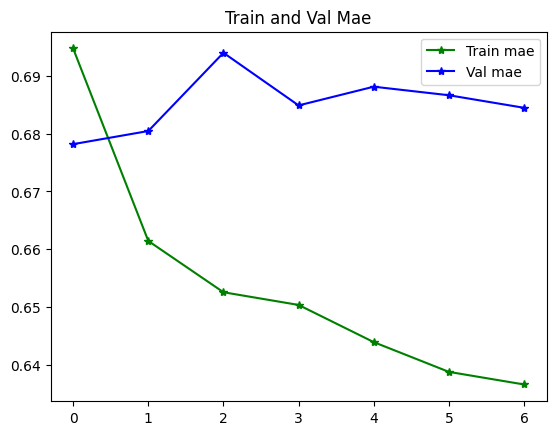

In [160]:
#Train and Validation Accuracy
plt.plot(history.history['loss'], 'g', marker='*', label='Train loss')
plt.plot(history.history['val_loss'], 'b', marker='*', label='Val loss')
plt.title('Train and Val loss')
plt.legend()
plt.figure()
#Train and Validation Loss
plt.plot(history.history['mae'], 'g', marker='*', label='Train mae')
plt.plot(history.history['val_mae'], 'b', marker='*', label='Val mae')
plt.title('Train and Val Mae')
plt.legend()
plt.show()


In [161]:
# Start measuring execution time for model prediction
start_exec = time.time()

# Predict on test data
predicted = model.predict(X_test)  # Model predictions

# End execution timer
end_exec = time.time()
execution_time = end_exec - start_exec  # Total execution time

# Calculate and print performance metrics
print('Mean Squared Error(MSE):', metrics.mean_squared_error(y_test, predicted))  # MSE
print('Root Mean Squared Error(RMSE):', np.sqrt(metrics.mean_squared_error(y_test, predicted)))  # RMSE
# print('R-squared(R2-Score):', metrics.r2_score(y_test, predicted))  # R2
print('Mean Absolute Error(MAE):', metrics.mean_absolute_error(y_test, predicted))  # MAE

# Inverse transform predictions and true values to original scale
predicted_value = target_scaler.inverse_transform(predicted)  # Predicted in original scale
real_value = target_scaler.inverse_transform(y_test.reshape(-1, 1))  # Actual values in original scale

# Create DataFrame for comparison
actualpred_df = pd.DataFrame({
    "Real": real_value.ravel(),
    "Predicted": predicted_value.ravel()
}, index = final_df.index[-len(real_value):])
print(actualpred_df.tail())

# Measure latency per prediction
start = time.time()
for i in range(min(1000, len(X_test))):
    _ = model.predict(X_test[i].reshape(1, X_test.shape[1], X_test.shape[2]), verbose=0)
end = time.time()
latency = (end - start) / min(1000, len(X_test))

# Measure throughput for batch predictions
start = time.time()
_ = model.predict(X_test)
end = time.time()
throughput = len(X_test) / (end - start)

print(f"\nLatency per prediction: {latency * 1000:.4f} ms")
print(f"Throughput: {throughput:.2f} predictions/sec")

print(f"Total Execution Time: {execution_time:.4f} seconds")  # Total time

# Measure memory usage
process = psutil.Process(os.getpid())  # Current process
memory_usage = process.memory_info().rss / (1024 ** 2)  # Memory in MB
print(f"Memory Usage: {memory_usage:.2f} MB")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
Mean Squared Error(MSE): 0.7225563916861456
Root Mean Squared Error(RMSE): 0.850033170932844
Mean Absolute Error(MAE): 0.6804703684530534
            Real  Predicted
Date                       
2025-09-16   6.0   9.165336
2025-09-17   6.0   9.731892
2025-09-18   5.0   9.922725
2025-09-19   7.0   9.586358
2025-09-20   6.0   8.919138
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step

Latency per prediction: 100.5683 ms
Throughput: 677.54 predictions/sec
Total Execution Time: 1.4774 seconds
Memory Usage: 2757.19 MB


In [162]:
import plotly.express as px
fig = px.line(actualpred_df.reset_index(), x=actualpred_df.index, y=actualpred_df.columns, title='Actual vs Predicted ')
fig.show()

## BILSTM + ATT FORECASTING

In [163]:


last_window = features_scaled[-WINDOW_SIZE:].copy()  # copy last WINDOW_SIZE rows to start forecasting

future_predictions = []
future_dates = []


last_date = merged_df.index[-1]

# Iteratively predict the next 7 days
current_window = last_window.copy()  # start with last known window
start_exec = time.time()
for i in range(7):
    # Predict next day using current window
    pred_scaled = model.predict(current_window[np.newaxis, :, :], verbose=0)  # predict (1, WINDOW_SIZE, n_features)

    # Inverse transform to get original scale
    future_pred = target_scaler.inverse_transform(pred_scaled)[0][0]
    future_predictions.append(future_pred)  # store prediction

    # Generate the date for the predicted day
    next_date = last_date + timedelta(days=i+1)
    future_dates.append(next_date)

    # Update the window: replace target with predicted value
    next_features = current_window[-1].copy()  # start with last day’s features
    next_features[feature_cols.index('crime_count')] = pred_scaled  # update target feature

    # Roll window forward
    current_window = np.vstack([current_window[1:], next_features])
end_exec = time.time()  # end timing
execution_time = end_exec - start_exec

# Create forecast dataframe with predicted values
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Crime_Count': future_predictions
})
forecast_df.set_index('Date', inplace=True)  # set Date as index
print(f"Total Execution Time for forecasting: {execution_time:.4f} seconds")
print("\n 7-Day Crime Forecast:")
forecast_df


Total Execution Time for forecasting: 0.8386 seconds

 7-Day Crime Forecast:


,Predicted_Crime_Count
Date,
2025-09-21,8.264727
2025-09-22,7.590312
2025-09-23,7.266221
2025-09-24,7.527758
2025-09-25,7.844129
2025-09-26,8.268035
2025-09-27,8.585248


In [164]:
fig = px.line(forecast_df.reset_index(), x='Date', y='Predicted_Crime_Count', title='7-Day Crime Forecast')
fig.show()

### 5.) Spatio Temporal CBAM ATTENTION

In [165]:

# CBAM Block
def cbam_block(x, ratio=8):
    # CHANNEL ATTENTION
    channel = x.shape[-1]
    shared_dense_one = Dense(channel // ratio, activation='relu', use_bias=False)
    shared_dense_two = Dense(channel, activation='sigmoid', use_bias=False)

    # Average pooling path
    avg_pool = GlobalAveragePooling1D()(x)
    avg_pool = Reshape((1, channel))(avg_pool)
    avg_pool = shared_dense_one(avg_pool)
    avg_pool = shared_dense_two(avg_pool)

    # Max pooling path
    max_pool = GlobalMaxPooling1D()(x)
    max_pool = Reshape((1, channel))(max_pool)
    max_pool = shared_dense_one(max_pool)
    max_pool = shared_dense_two(max_pool)

    # Combine channel attention and apply
    channel_attention = Add()([avg_pool, max_pool])
    channel_attention = Activation('sigmoid')(channel_attention)
    x = Multiply()([x, channel_attention])

    #  SPATIAL ATTENTION
    avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(x)
    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(x)
    concat = Concatenate(axis=-1)([avg_pool, max_pool])
    spatial_attention = Conv1D(filters=1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    x = Multiply()([x, spatial_attention])

    return x

#  MODEL WITH CBAM
inputs = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))  # input shape: (timesteps, features)

# Stack Bidirectional LSTM layers with Dropout
x = Bidirectional(LSTM(128, return_sequences=True))(inputs)
x = Dropout(0.7)(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Dropout(0.7)(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Dropout(0.7)(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Dropout(0.7)(x)

# Apply CBAM attention
x = cbam_block(x)

# Flatten and Dense layers
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.7)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.7)(x)

# Output layer
outputs = Dense(1)(x)  # regression output

# Build model
model = Model(inputs, outputs)
model.summary()


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 7, 15)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_16    │ (None, 7, 256)    │    147,456 │ input_layer_9[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 7, 256)    │          0 │ bidirectional_16… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_17    │ (None, 7, 256)    │    394,240 │ dropout_28[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 7, 256)    │          0 │ bidirectional_17… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_18    │ (None, 7, 128)    │    164,352 │ dropout_29[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 7, 128)    │          0 │ bidirectional_18… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_19    │ (None, 7, 128)    │     98,816 │ dropout_30[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 7, 128)    │          0 │ bidirectional_19… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ dropout_31[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ dropout_31[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 128)    │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1, 128)    │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 1, 16)     │      2,048 │ reshape_2[0][0],  │
│                     │                   │            │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 1, 128)    │      2,048 │ dense_27[0][0],   │
│                     │                   │            │ dense_27[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1, 128)    │          0 │ dense_28[0][0],   │
│                     │                   │            │ dense_28[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 1, 128)    │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 870,608 (3.32 MB)

 Trainable params: 870,608 (3.32 MB)

 Non-trainable params: 0 (0.00 B)

In [166]:
# Model compilation
model.compile(optimizer='adam', loss='mse',metrics=['mae'])

In [167]:
# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=64,
    verbose=1,
    callbacks=[early_stop, lr_reduce]
)

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 161ms/step - loss: 0.9712 - mae: 0.7804 - val_loss: 0.7512 - val_mae: 0.6798 - learning_rate: 0.0010
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step - loss: 0.8636 - mae: 0.7221 - val_loss: 0.7340 - val_mae: 0.6742 - learning_rate: 0.0010
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - loss: 0.8776 - mae: 0.7204 - val_loss: 0.7426 - val_mae: 0.6798 - learning_rate: 0.0010
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - loss: 0.8940 - mae: 0.7409 - val_loss: 0.7176 - val_mae: 0.6787 - learning_rate: 0.0010
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - loss: 0.8341 - mae: 0.7270 - val_loss: 0.7594 - val_mae: 0.6890 - learning_rate: 0.0010
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.8001 - mae: 0.6976
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - loss: 0.8010 - mae: 0.6979 - val_loss: 0.7567 - val_mae: 0.6865 - learning_rate: 0.0010
E

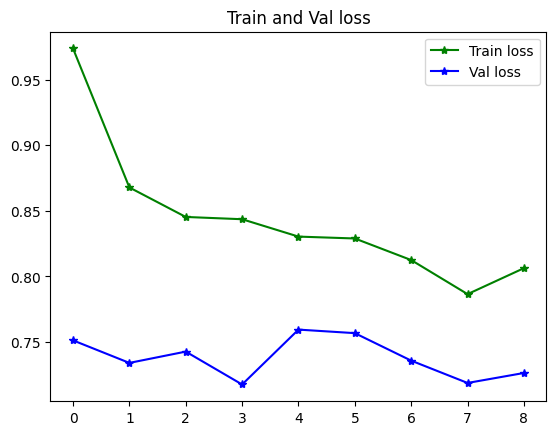

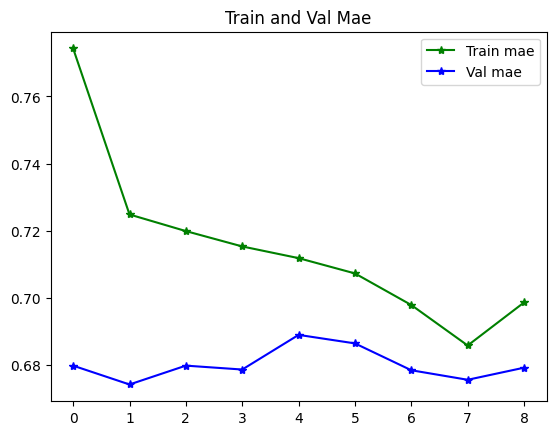

In [168]:
#Train and Validation Accuracy
plt.plot(history.history['loss'], 'g', marker='*', label='Train loss')
plt.plot(history.history['val_loss'], 'b', marker='*', label='Val loss')
plt.title('Train and Val loss')
plt.legend()
plt.figure()
#Train and Validation Loss
plt.plot(history.history['mae'], 'g', marker='*', label='Train mae')
plt.plot(history.history['val_mae'], 'b', marker='*', label='Val mae')
plt.title('Train and Val Mae')
plt.legend()
plt.show()


In [169]:
# Start measuring execution time for model prediction
start_exec = time.time()

# Predict on test data
predicted = model.predict(X_test)  #

# End execution timer
end_exec = time.time()
execution_time = end_exec - start_exec

# Calculate and print performance metrics
print('Mean Squared Error(MSE):', metrics.mean_squared_error(y_test, predicted))  # MSE
print('Root Mean Squared Error(RMSE):', np.sqrt(metrics.mean_squared_error(y_test, predicted)))  # RMSE

print('Mean Absolute Error(MAE):', metrics.mean_absolute_error(y_test, predicted))  # MAE

# Inverse transform predictions and true values to original scale
predicted_value = target_scaler.inverse_transform(predicted)  # Predicted in original scale
real_value = target_scaler.inverse_transform(y_test.reshape(-1, 1))  # Actual values in original scale

# Create DataFrame for comparison
actualpred_df = pd.DataFrame({
    "Real": real_value.ravel(),
    "Predicted": predicted_value.ravel()
}, index = final_df.index[-len(real_value):])
print(actualpred_df.tail())

# Measure latency per prediction
start = time.time()
for i in range(min(1000, len(X_test))):
    _ = model.predict(X_test[i].reshape(1, X_test.shape[1], X_test.shape[2]), verbose=0)
end = time.time()
latency = (end - start) / min(1000, len(X_test))

# Measure throughput for batch predictions
start = time.time()
_ = model.predict(X_test)
end = time.time()
throughput = len(X_test) / (end - start)


print(f"\nLatency per prediction: {latency * 1000:.4f} ms")
print(f"Throughput: {throughput:.2f} predictions/sec")


print(f"Total Execution Time: {execution_time:.4f} seconds")

# Measure memory usage
process = psutil.Process(os.getpid())
memory_usage = process.memory_info().rss / (1024 ** 2)
print(f"Memory Usage: {memory_usage:.2f} MB")


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step
Mean Squared Error(MSE): 0.7175625013054472
Root Mean Squared Error(RMSE): 0.8470906098555497
Mean Absolute Error(MAE): 0.6786848418724257
            Real  Predicted
Date                       
2025-09-16   6.0   9.329370
2025-09-17   6.0   9.704031
2025-09-18   5.0   9.846185
2025-09-19   7.0   9.510449
2025-09-20   6.0   8.986094
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

Latency per prediction: 103.8562 ms
Throughput: 1001.37 predictions/sec
Total Execution Time: 2.8314 seconds
Memory Usage: 2906.28 MB


In [170]:
import plotly.express as px
fig = px.line(actualpred_df.reset_index(), x=actualpred_df.index, y=actualpred_df.columns, title='Actual vs Predicted ')
fig.show()

# FORECASTING

In [171]:


last_window = features_scaled[-WINDOW_SIZE:].copy()

future_predictions = []
future_dates = []


last_date = merged_df.index[-1]

# Iteratively predict the next 7 days
current_window = last_window.copy()
start_exec = time.time()
for i in range(7):
    # Predict next day using current window
    pred_scaled = model.predict(current_window[np.newaxis, :, :], verbose=0)  # predict (1, WINDOW_SIZE, n_features)

    # Inverse transform to get original scale
    future_pred = target_scaler.inverse_transform(pred_scaled)[0][0]
    future_predictions.append(future_pred)  # store prediction

    # Generate the date for the predicted day
    next_date = last_date + timedelta(days=i+1)
    future_dates.append(next_date)

    # Update the window: replace target with predicted value
    next_features = current_window[-1].copy()  # start with last day’s features
    next_features[feature_cols.index('crime_count')] = pred_scaled  # update target feature

    # Roll window forward
    current_window = np.vstack([current_window[1:], next_features])
end_exec = time.time()
execution_time = end_exec - start_exec

# Create forecast dataframe with predicted values
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Crime_Count': future_predictions
})
forecast_df.set_index('Date', inplace=True)  # set Date as index
print(f"Total Execution Time for forecasting: {execution_time:.4f} seconds")
print("\n 7-Day Crime Forecast:")
forecast_df


Total Execution Time for forecasting: 0.6959 seconds

 7-Day Crime Forecast:


,Predicted_Crime_Count
Date,
2025-09-21,8.461720
2025-09-22,8.173083
2025-09-23,8.347445
2025-09-24,8.827585
2025-09-25,9.162548
2025-09-26,9.568876
2025-09-27,9.863860


In [172]:
import plotly.express as px

fig = px.line(forecast_df.reset_index(), x='Date', y='Predicted_Crime_Count', title='7-Day Crime Forecast')
fig.show()

In [173]:
# Get the last 20 records from the original merged_df
last_20_actual = merged_df['crime_count'].tail(20).reset_index()
last_20_actual.columns = ['Date', 'Crime_Count']
last_20_actual['Type'] = 'Actual'

# Prepare the forecasted data
forecast_df_plot = forecast_df.reset_index()
forecast_df_plot.columns = ['Date', 'Crime_Count']
forecast_df_plot['Type'] = 'Forecast'

# Combine the dataframes
combined_df = pd.concat([last_20_actual, forecast_df_plot])

# Plot
fig = px.line(combined_df, x='Date', y='Crime_Count', color='Type',
              title='Last 20 Actual Crime Counts and 7-Day Forecast')
fig.show()


Top LIME explanation (feature, weight):
        feature    weight
      lag_7_t-6  0.047560
crime_count_t-2  0.046743
crime_count_t-3  0.045633
      lag_7_t-7  0.045183
      lag_7_t-3  0.044861
crime_count_t-4  0.043330
      lag_7_t-2  0.038602
crime_count_t-6  0.035397
crime_count_t-5  0.034823
      lag_1_t-5  0.029073
      lag_1_t-4  0.027265
weekend_avg_t-7  0.020982
day_of_week_t-6  0.020348
day_of_week_t-7  0.019171
weekend_avg_t-6  0.018856
   District_t-2 -0.018011
 is_weekend_t-7  0.013542
   District_t-3 -0.013427
day_of_week_t-5  0.013372
 is_weekend_t-6  0.012344

Corresponding instance values (unscaled) for explained features (first 30 shown):
        feature    scaled      original
crime_count_t-7 -0.195757  7.000000e+00
     Arrest_t-7 -0.647374  1.936085e-08
   District_t-7 -0.012302  2.000000e+00
day_of_week_t-7  1.000639  5.000000e+00
 is_weekend_t-7  1.581987  1.000000e+00
 is_holiday_t-7 -0.183823 -1.350846e-09
weekday_avg_t-7  0.394134  8.229226e+00
  month_av

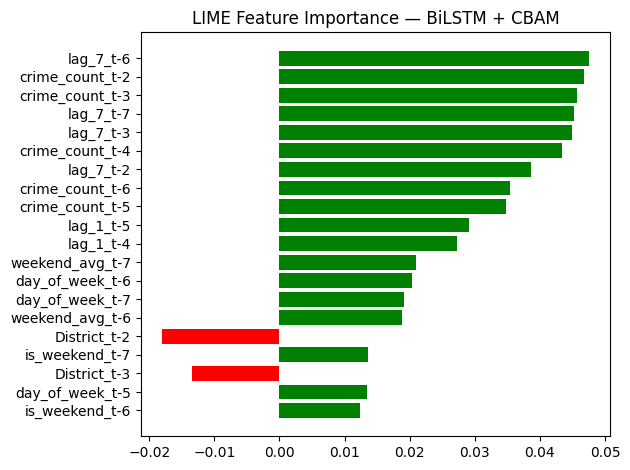

In [174]:
# LIME explanation for BiLSTM + CBAM (regression)

#  CONFIG
explain_index = -1   # choose sample to explain (last test sample)
n_features_to_show = 20  # number of top features to show in explanation
n_samples_in_lime = 5000   # number of perturbed samples LIME will use
html_output = "lime_bilstm_cbam_explanation.html"  # output HTML file

# Sanity checks
assert 'X_train' in globals() and 'X_test' in globals(), "X_train / X_test must exist"  # check data
assert X_train.ndim == 3 and X_test.ndim == 3, "X_train and X_test should be (N, window, n_features)"  # shape check
window_size = X_train.shape[1]  # number of timesteps
n_features = X_train.shape[2]   # number of features
assert window_size * n_features == X_train.reshape(len(X_train), -1).shape[1]  # flatten check

# Build feature names for each timestep and feature
feat_names = []
for t in range(window_size):
    lag = window_size - t  # time lag relative to prediction
    for f in feature_cols:
        feat_names.append(f"{f}_t-{lag}")  # e.g., "crime_count_t-7"

# Flatten training and test data for LIME
X_train_flat = X_train.reshape(len(X_train), -1)  # shape: (n_samples, window*n_features)
X_test_flat = X_test.reshape(len(X_test), -1)    # same shape for test


# Define predict function for LIME
def lime_predict_fn(flat_batch):
    """
    Predict function for LIME
    flat_batch: np.array shape (B, window*n_features)
    returns: np.array shape (B,) of model outputs
    """
    X_batch = flat_batch.reshape((flat_batch.shape[0], window_size, n_features)).astype(np.float32)  # reshape
    preds = model.predict(X_batch, verbose=0)  # model prediction
    preds = np.array(preds).reshape(-1)  # flatten
    return preds

#  Build LIME explainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train_flat.astype(np.float32),
    feature_names=feat_names,  # feature names
    mode='regression',
    discretize_continuous=False,
)

#  Choose instance to explain
flat_instance = X_test_flat[explain_index].astype(np.float32)

#  Run LIME explanation
exp = explainer.explain_instance(
    data_row=flat_instance,  # instance to explain
    predict_fn=lime_predict_fn,  # LIME prediction function
    num_features=n_features_to_show,  # top features
    num_samples=n_samples_in_lime  # perturbed samples
)

# Get explanation as list and dataframe
exp_list = exp.as_list(label=0)  # list of (feature, weight)
exp_df = pd.DataFrame(exp_list, columns=['feature', 'weight'])

#  Inverse transform features for readability
try:
    flat_instance_2d = flat_instance.reshape(1, -1)
    inv_original_values = []
    inst_window = flat_instance.reshape(window_size, n_features)  # reshape to (window, n_features)
    try:
        inv_rows = feature_scaler.inverse_transform(inst_window)  # inverse transform scaled values
        readable = []
        for t in range(window_size):
            lag = window_size - t
            for fi, fname in enumerate(feature_cols):
                scaled_val = inst_window[t, fi]
                orig_val = inv_rows[t, fi]
                readable.append({'feature': f"{fname}_t-{lag}", 'scaled': scaled_val, 'original': orig_val})
        readable_df = pd.DataFrame(readable)
    except Exception:
        readable_df = None
except Exception:
    readable_df = None


print("\nTop LIME explanation (feature, weight):")
print(exp_df.head(n_features_to_show).to_string(index=False))

if readable_df is not None:
    print("\nCorresponding instance values (unscaled) for explained features (first 30 shown):")
    print(readable_df.head(30).to_string(index=False))

# Save interactive HTML explanation
exp.save_to_file(html_output)
print(f"\nSaved interactive LIME explanation to: {os.path.abspath(html_output)}")


try:
    fig = exp.as_pyplot_figure()
    plt.title("LIME Feature Importance — BiLSTM + CBAM")
    plt.tight_layout()
    plt.show()
except Exception:
    pass




# Result and Discussion